# CS436 PA1 Image Warping

Run the following cell, in order to mount your drive with this notebook.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Importing Libraries

This might take a few seconds. If any library is missing, make sure to install it in your environment, using anaconda in for library installation is usually easier

In [2]:
import matplotlib
import imageio
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
%matplotlib inline
# %matplotlib notebook

import seaborn as sns
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

# 1. Image Warping

In this section, <b>you are not allowed to use any OpenCV functions.</b> OpenCV comes in the next section

## Task 1.1 - Part A (Projective Transformations)


In this section you will be creating a function `warpPerspective(img,M,(cols,rows))`. 
The function performs a projective transformation on an image and returns a new image variable
    
    This function has the following arguments:
        img: original image variable. This can be a black and white or a color image
        M: a 3x3 projective transformation matrix
        cols: the columns of the output image
        rows: the rows of the output matrix        

The function can transform a small image to a larger image. While doing so, the new image must not have any fringes or emply pixels, you can fill those pixels by taking the value of the nearest neigbouring pixel. The pixels outside of an image may be set to black for now. You may change the arguments of the function if you want to add additional features

# Functions for image manipulations and reading/printing

In [3]:
cat_path = 'part1/cat.jpg' # global variable for cat image path so don't need to type again and again for part 1

def show_img(img):
    figure(dpi = 100)
    
    # plt.axis('off') # allows us to turn axis on or off
    
    plt.imshow(img)
    plt.show()

def read_img(img_path):
    img = np.array(mpimg.imread(img_path))
    img.setflags(write=1) # allows us to manipulate the image
    return img

def show_cropped_img(img, row_start, row_end, col_start, col_end): # For displaying cropped image
    figure(dpi = 150)
    
    # plt.axis('off') # Use to turn axis on or off
    
    plt.imshow(img[row_start:row_end,col_start:col_end])
    plt.show()
    
def crop_img(img, row_start, row_end, col_start, col_end): # For just cropping the image
    cropped = img[row_start:row_end,col_start:col_end]
    return cropped

In [41]:
def nearest_neighbor_interpolate(img, reverse_map, x_bounds, y_bounds):
    
    # x_bounds repetitions, y_bounds rows, and 3 columns (rgb values)
    # Image variable is a 3D array. In other words, it is a 2D array of pixels with values for rgb. 
    # The variable for each color is an 8 bit integer ranging from 0-255.
    # Taken from intro notebook provided with assignment files
    # I want my output image with optimized values of rows and columns hence using those values now
    # Initially empty pixels (all zeroes/absence of light or black color)
    
    interpolated = np.zeros((x_bounds, y_bounds, 3))
    
    # A portion of the output of above line
    
 #   [[[0 0 0]
 # [0 0 0]
 # [0 0 0]
 # ...
 # [0 0 0]
 # [0 0 0]
 # [0 0 0]]
    
    # We need to convert it into int
    
    interpolated = interpolated.astype(int)

    for i in range(x_bounds):
        for j in range(y_bounds):
            # [0, 0, 1], [0, 1, 1], ... [x_bounds, y_bounds, 1]    
            # Reverse transformation
            # Now taking each pixel mapping it back to original photo and assigning value of neighbor pixel
            # Pixels outside of image are set to black i.e [0, 0, 0] values for rgb
            
            assigned = np.round(np.matmul(reverse_map, np.array([i,j,1]))) # 3x3 * 3x1 (output = 3x1 matrix (row, column, 1))
            
            # If pixels are outside range of image assign them black
            
            if assigned[0] < 0 or assigned[0] >= rows:
                interpolated[i][j] = np.array([0,0,0]) 
                
            elif assigned[1] < 0 or assigned[1] >= cols:
                interpolated[i][j] = np.array([0,0,0])
                
            # Else assign nearest neighbor value from original image
                
            else:
                a = assigned[0] # row
                b = assigned[1] # col
                a = int(a)
                b = int(b)
                interpolated[i][j] = img[a, b] # taking value of nearestneighbor pixel in original cropped image
    
    return interpolated    

In [42]:
def warpPerspective(img, M, dsize, x_bounds, y_bounds): # additional features added : x_bounds, y_bounds
    dst = M.copy()
    col = dsize[0] # 113 as calculated in Task 1.1 part b
    row = dsize[1] # 156 as calculated in Task 1.1 part b
    
    # Extreme corner points (0, 0), (156, 0), (0, 113), and (156, 113) for cropped cat image
    
    untransformed_pts = np.array([
        [0, row, 0, row], 
        [0, 0, col, col], 
        [1, 1, 1, 1]
    ])
    
    transformed_pts = np.matmul(dst, untransformed_pts)  # transformation matrix multiplied by points to be transformed
    
    # Output of above matrix multiplication for this test case
    # [[  0.         135.09996299 -56.5         78.59996299]
    #  [  0.          78.          97.86087063 175.86087063]
    #  [  1.           1.           1.           1.        ]]
    
    # Explanation already provided in Task 1.1 part b for finding minimum values of x and y from 2d array
    # Minimum value of x in this test case is -56.49999999999999 and minimum value of y is 0.0
    
    translation_matrix = np.array([
        [1, 0, -(np.amin(transformed_pts, axis=1)[0])],
        [0, 1, -(np.amin(transformed_pts, axis=1)[1])],
        [0, 0, 1]
    ])

    reverse_map = np.matmul(np.linalg.inv(dst), np.linalg.inv(translation_matrix)) # both are 3x3 matrices
    
    # Output of above matrix multiplication for this test case
    # [[  0.8660254    0.5        -48.93043531]
    # [ -0.5          0.8660254   28.25      ]
    # [  0.           0.           1.        ]]

    # Now filling in empty pixels/fringes using nearest neighbor interpolation
    # Idea taken from : https://www.imageeprocessing.com/2017/11/nearest-neighbor-interpolation.html
    
    interpolated = nearest_neighbor_interpolate(img, reverse_map, x_bounds, y_bounds)
    
    return interpolated

## Task 1.1 - Part B: Rotation



In this test case, we will be rotating a subsection of an image of a cat. We will convert `cat.jpg` to `cat_sol0_1.jpg`



We can utilize your newly made function for that with the following steps

1. Read the file `part1/cat.jpg`
2. Crop it to the portion that shows just the head
3. Input it to your function with your projective matrix
4. Display the output
5. You can adjust the row and col values such that the entirety of the output image is shown
    
The output should look similar to `part1/cat_sol0_1.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those

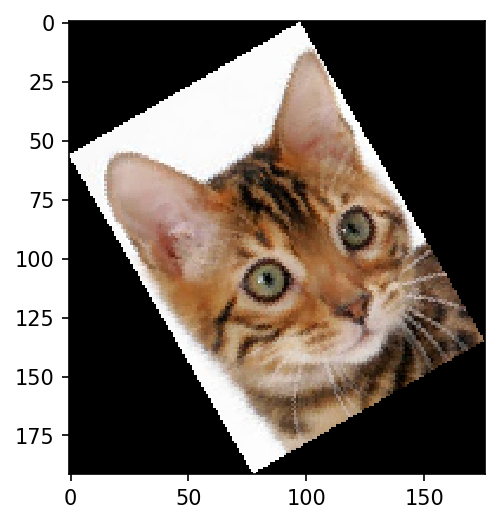

In [43]:
#TODO

# Reading the file part1/cat.jpg

cat = read_img(cat_path) 

# Cropped to the portion to show just the head

cat_crop = crop_img(cat, 0, 157, 85, 199) # 0 to 157 horizontal and 85 to 199 vertical (inclusive)

dimension = cat_crop.shape # (157, 114, 3)
rows = dimension[0] # 157 rows
cols = dimension[1] # 114 columns

rows = rows - 1 # Since indexing starts from 0 so we have to subtract 1 from overall rows i.e 0 to 156
cols = cols - 1 # Since indexing starts from 0 so we have to subtract 1 from overall columns i.e 0 to 113

angle = 30 # In degrees
positive_degree = np.radians(angle) # Converted to radians
negative_degree = np.radians(-angle) # Since rotation matrix has the form [cos(θ) -sin(θ) sin(θ) cos(θ)] 2 by 2 rotation matrix

# My projective matrix

M = np.array([
        [np.cos(positive_degree), np.sin(negative_degree), 0],
        [np.sin(positive_degree), np.cos(positive_degree), 0],
        [0, 0, 1]
    ]) # your 3x3 matrix

# cos(θ)  -sin(θ)

# sin(θ)   cos(θ)

# I want to transform 'untransformed_pts' to the bounds of output image i.e to 'transformed_pts'
# This way I will be able to extract transformation matrix 'M' as well (for entire image)

untransformed_pts = np.float32([[0,0],[114,0],[0,157],[114,157]]) # source cropped cat image (extreme corner points)

# transformed_pts would be np.float32([[0,0],[r,0],[0,c],[r,c]]) (destination rotated/warped (cropped) cat image)

# (0, 0) maps to (0, 0) (self explanatory)
# (157, 0) maps to (r, 0) since 157 will map to some unknown location on output image
# Similar explanation for remaining two points

# Converting untransformed points to matrix form

untransformed_pts = np.array([
        [0, rows, 0, rows], 
        [0, 0, cols, cols], 
        [1, 1, 1, 1]
    ])

# 3x3 rotation matrix multiplied by by 3x4 coordinates matrix. Output will be a 3x4 matrix

transformed_pts = np.matmul(M, untransformed_pts) 

# axis=1 means we are finding maximum row wise
# there are 3 rows so output would be in the form [x, y, z] where x, y, z are points from the transformed_pts matrix
# [0] would give us max from the first row which is basically max value of x

maximum_x_value = np.amax(transformed_pts, axis=1)[0]

# axis=1 means we are finding maximum row wise
# there are 3 rows so output would be in the form [x, y, z] where x, y, z are points from the transformed_pts matrix
# [1] would give us max from the second row which is basically maximum value of y

maximum_y_value = np.amax(transformed_pts, axis=1)[1]

# last row is un-needed (in transformed_pts matrix) since its just homogenous coordinates so last row contains 1's as usual

# Similarly I found minimum values of x and y from the transformed_pts matrix

minimum_x_value = np.amin(transformed_pts, axis=1)[0]
minimum_y_value = np.amin(transformed_pts, axis=1)[1]

# Founding bounds/ range of x and y now (converting to int will give as our optimal/required values of rows and columns)
# These optimal values are for output image bounds

x_bounds = int(np.round(maximum_x_value - minimum_x_value)) # 192 optimal rows
y_bounds = int(np.round(maximum_y_value - minimum_y_value)) # 176 optimal columns

# x_bounds, y_bounds are extra features added to the function

cat_sol0_1 = warpPerspective(cat_crop, M, (cols, rows), x_bounds, y_bounds) 

figure(dpi = 150)
plt.imshow(cat_sol0_1)
plt.show()

# 2. Interpolation

At this point, you can predict that creating a large image from small image will not give us the best results, ie there will be a lot of empty pixel values. There are multiple ways to handle this, i.e. Bilinear Interpolation, Nearest, Bicubic etc. However, the method that we will be utilizing in this assignment is fairly simple. We will be replacing empty pixel values with the average of all pixel values around that pixel. Be careful, while handling the corner/side pixels of the image.



## Task 2.1


For this, we can augment your function `warpPerspective(img,M,(cols,rows))`.

1. Where you previously took the nearest neighbor to fill missing pixels, use the `Interpolation` algorithm. 
2. Input cols and rows values as 2000 and 2160
3. Use the same projective matrix
4. Display the output
    
the output should look similar to `part1/cat_sol1.jpg`.

In [44]:
# rows and cols are values of output image
# r and c are values of cropped cat image
# rev is the reverse transformation matrix or inverse transformation matrix
# img is the cropped cat image

def interpolation_algorithm(rows, cols, rev, r, c, img):
    
    # Image variable is a 3D array. In other words, it is a 2D array of pixels with values for rgb. 
    # The variable for each color is an 8 bit integer ranging from 0-255.
    # Taken from intro notebook provided with assignment files
    # I want my output image with optimized values of rows and columns hence using those values now
    # Initially empty pixels (all zeroes/absence of light or black color)
    
    interpolated = np.zeros((rows, cols, 3))
    
    # A portion of the output of above line
    
     #   [[[0 0 0]
     # [0 0 0]
     # [0 0 0]
     # ...
     # [0 0 0]
     # [0 0 0]
     # [0 0 0]]
    
    # We need to convert it into int
    
    interpolated = interpolated.astype(int)
    
    for i in range(rows):
        for j in range(cols):
            # [0, 0, 1], [0, 1, 1], ... [rows, cols, 1]    
            # Reverse transformation
            # Now taking each pixel mapping it back to original photo and assigning average pixel values of 4 pixels
            # Pixels outside of image are ignored
            # i.e if pixel values are greater than cropped image cols and rows we ignore since they already black
            
            assigned = np.matmul(rev, np.array([i,j,1])) # 3x3 * 3x1 (output = 3x1 matrix (row, column, 1))
            
            Foundx = int(assigned[0])
            Foundy = int(assigned[1])
            
            # assigned[0] are the row and assigned[1] are the column value of reverse mapped pixel
            # if it is outside our boundary just ignore it else assign average value from original cropped image
            
            if (assigned[0] >= 0 and assigned[1] >= 0 and assigned[0] < r and assigned[1] < c):
                
                # Conditions for boundaries 
                
                if Foundx == 0 and Foundy == c-1: # top right
                    first_point = img[Foundx + 1, Foundy]
                    second_point = img[Foundx, Foundy - 1]
                    third_point = img[Foundx + 1, Foundy - 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                elif Foundx == 0 and Foundy == 0: # top left
                    first_point = img[Foundx + 1, Foundy]
                    second_point = img[Foundx, Foundy + 1]
                    third_point = img[Foundx + 1, Foundy + 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                elif Foundx == r-1 and Foundy == c-1: # bottom right
                    first_point = img[Foundx - 1, Foundy]
                    second_point = img[Foundx, Foundy - 1]
                    third_point = img[Foundx - 1, Foundy - 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                elif Foundx == r-1 and Foundy == 0: # bottom left
                    first_point = img[Foundx - 1, Foundy]
                    second_point = img[Foundx, Foundy + 1]
                    third_point = img[Foundx - 1, Foundy + 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                 # If along the boundary lines   
                    
                elif Foundx == 0:
                    first_point = img[Foundx + 1, Foundy]
                    second_point = img[Foundx, Foundy + 1]
                    third_point = img[Foundx, Foundy - 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                elif Foundy == 0:
                    first_point = img[Foundx - 1, Foundy]
                    second_point = img[Foundx + 1, Foundy]
                    third_point = img[Foundx, Foundy + 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                elif Foundx == r - 1:
                    first_point = img[Foundx - 1, Foundy]
                    second_point = img[Foundx, Foundy - 1]
                    third_point = img[Foundx, Foundy + 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                elif Foundy == c - 1:
                    first_point = img[Foundx - 1, Foundy]
                    second_point = img[Foundx + 1, Foundy]
                    third_point = img[Foundx, Foundy - 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]))/3)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]))/3)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]))/3)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                    
                # If in between the grid
                
                else:
                    first_point = img[Foundx + 1, Foundy]
                    second_point = img[Foundx - 1, Foundy]
                    third_point = img[Foundx, Foundy - 1]
                    fourth_point = img[Foundx, Foundy + 1]
                    
                    avg_x = int((int(first_point[0]) + int(second_point[0]) + int(third_point[0]) + int(fourth_point[0]))/4)
                    avg_y = int((int(first_point[1]) + int(second_point[1]) + int(third_point[1]) + int(fourth_point[1]))/4)
                    avg_z = int((int(first_point[2]) + int(second_point[2]) + int(third_point[2]) + int(fourth_point[2]))/4)
                    interpolated[i, j, :] = np.array([avg_x, avg_y, avg_z],dtype=np.uint8)
                
            else: # if outside bounds of cat image (cropped) 
                continue
                           
    return interpolated

In [45]:
def reverse_map(x, y, dst): # x is minimum value of x and y is minimum value of y
    if x < 0 or y < 0:
        translation_matrix = np.array([
        [1, 0, -x],
        [0, 1, -y],
        [0, 0, 1]
    ])
        
        rev = np.matmul(np.linalg.inv(dst), np.linalg.inv(translation_matrix)) # both are 3x3 matrices
    
    else:
        rev =  np.linalg.inv(dst) # 3x3 transformation matrix 'M'
        
    return rev

In [46]:
def augmented_warpPerspective(img, M, dsize): 
    dst = M.copy()
   
    # Subtracting 1 because indexing starts at 0
    
    dimension = img.shape
    row = dimension[0] - 1 # 156 rows
    col = dimension[1] - 1 # 113 columns
    
    # Extreme corner points (0, 0), (156, 0), (0, 113), and (156, 113) for cropped cat image
    
    untransformed_pts = np.array([
        [0, row, 0, row], 
        [0, 0, col, col], 
        [1, 1, 1, 1]
    ])
    
    transformed_pts = np.matmul(dst, untransformed_pts)  # transformation matrix multiplied by points to be transformed
    
    # Output of above matrix multiplication for this test case
    # [[  0.         135.09996299 -56.5         78.59996299]
    #  [  0.          78.          97.86087063 175.86087063]
    #  [  1.           1.           1.           1.        ]]
    
    # Explanation already provided in Task 1.1 part b for finding minimum values of x and y from 2d array
    # Minimum value of x in this test case is -56.49999999999999 and minimum value of y is 0.0
    
    # Here I just calculated the inverse and inverse transformation matrix
    # Interpolation will be done later (using average interpolation algorithm as described in question)
    
    rev = reverse_map(np.amin(transformed_pts, axis=1)[0], np.amin(transformed_pts, axis=1)[1], dst)
    
    return rev

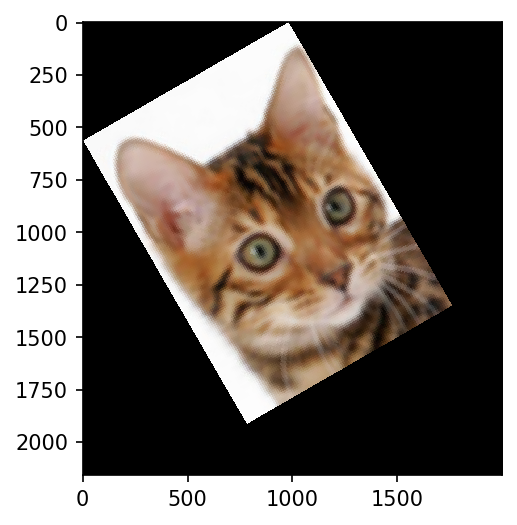

In [47]:
#TODO

# Reading the file part1/cat.jpg

cat = read_img(cat_path) 

# Cropped to the portion to show just the head

cat_crop = crop_img(cat, 0, 157, 85, 199) # 0 to 157 horizontal and 85 to 199 vertical (inclusive)

# These are rows and columns of cropped cat image

dimension = cat_crop.shape # (157, 114, 3)
r = dimension[0] - 1  # 156 rows since indexing starts at 0
c = dimension[1] - 1  # 113 columns since indexing starts at 0

angle = 30 # In degrees
positive_degree = np.radians(angle) # Converted to radians
negative_degree = np.radians(-angle) # Since rotation matrix has the form [cos(θ) -sin(θ) sin(θ) cos(θ)] 2 by 2 rotation matrix

# My projective matrix

old_M = np.array([
        [np.cos(positive_degree), np.sin(negative_degree), 0],
        [np.sin(positive_degree), np.cos(positive_degree), 0],
        [0, 0, 1]
    ]) # your 3x3 matrix

# cos(θ)  -sin(θ)

# sin(θ)   cos(θ)

scale_factor = 10

# scaling matrix

s = np.array([
    [scale_factor, 0, 0],
    [0, scale_factor, 0],
    [0, 0, 1]
])

# rotation matrix concatenated with scale matrix
# I did this because there is no scale factor in original 'M' that I used earliar
# Hence output image would be of same size as the output from cv2 (built in function) gives
# So we can multiply with scale factor depending on dsize

M = np.matmul(old_M, s)

# These are cols and rows of output image

cols = 2000 # already given in question
rows = 2160 # already given in question

rev = augmented_warpPerspective(cat_crop, M, (cols, rows)) 

interpolated = interpolation_algorithm(rows, cols, rev, r, c, cat_crop)

figure(dpi = 150)
plt.imshow(interpolated)
plt.show()

# 3. Image Alpha Values



In this section we will be blending two images to create a third image. This process is important in applications such as VR, AR etc.

For this section, it is important to understand alpha values. Alpha values range between 0.0 and 1.0, and determine the transparency of a pixel. These are common in png files where they are stored alongside rgb as rgba. 

## Task 3.1

You must manipulate your `warpPerspective(img,M,(cols,rows))` function so that it returns values in the form of rgba. You can do this with the following steps: 

1. If the image has values in 8bit integers, convert your 0 - 255 color integer value range to 0.0 - 1.0 float. 
2. Append a forth pixel value for the alpha
3. It might be easier to create a seperate function that converts rgb to rgba with alpha values set to 1.0
4. Where you were previously setting the background to be black, also set the alpha to 0.0
    
The output from the previous test should look similar to `part1/cat_sol2.png`. you can explore the png file structure to get a better idea of the output. 




In [48]:
# Bilinear Interpolation Functions

# Adopted from lecture slides (L3_L4 slide number 48)

def assign_corners(coordinate): # coordinates at extreme points
    TopLeft = (int(coordinate[0]), int(coordinate[1]))
    TopRight = (int(coordinate[0]), int(coordinate[1]) + 1)
    BottomLeft = (int(coordinate[0]) + 1, int(coordinate[1]))
    BottomRight = (int(coordinate[0]) + 1, int(coordinate[1]) + 1)
    
    return TopLeft, TopRight, BottomLeft, BottomRight

def interpolate_top(assigned, img, TopRight, TopLeft): # Top Border
    part1 = (assigned[1] - TopLeft[1]) * img[TopRight[0], TopRight[1]]
    part2 = (TopRight[1] - assigned[1] ) * img[TopLeft[0], TopLeft[1]]
    value = part1 + part2
    return value
 
def interpolate_bottom(assigned, img, BottomRight, BottomLeft): # Lower Border
    part1 = (assigned[1] - BottomLeft[1]) * img[BottomRight[0], BottomRight[1]]
    part2 = (BottomRight[1] - assigned[1]) * img[BottomLeft[0], BottomLeft[1]]
    value = part1 + part2
    return value

def interpolate_side(assigned, TopLeft, Bottom, BottomLeft, Top): # Left and Right border
    part1 = (assigned[0] - TopLeft[0]) * Bottom
    part2 = (BottomLeft[0] - assigned[0]) * Top
    value = part1 + part2
    return value

In [49]:
def manipulated_warpPerspective(img, M, dsize): 
    dst = M.copy()
   
    # Subtracting 1 because indexing starts at 0
    
    dimension = img.shape
    r = dimension[0] - 1 # 156 rows
    c = dimension[1] - 1 # 113 columns
    
    # Extreme corner points (0, 0), (156, 0), (0, 113), and (156, 113) for cropped cat image
    
    untransformed_pts = np.array([
        [0, r, 0, r], 
        [0, 0, c, c], 
        [1, 1, 1, 1]
    ])
    
    transformed_pts = np.matmul(dst, untransformed_pts)  # transformation matrix multiplied by points to be transformed
    
    # Explanation already provided in Task 1.1 part b for finding minimum values of x and y from 2d array
    # Minimum value of x in this test case is -56.49999999999999 and minimum value of y is 0.0
    
    rev = reverse_map(np.amin(transformed_pts, axis=1)[0], np.amin(transformed_pts, axis=1)[1], dst)
      
    # rows and cols are values of output image
    # r and c are values of cropped cat image

    cols = dsize[0]
    rows = dsize[1]
    
    # Now added fourth pixel value for alpha 
    
    interpolated = np.zeros((rows, cols, 4))
    
    for i in range(rows):
        for j in range(cols):
            # Reverse transformation
            # Now taking each pixel mapping it back to original photo and using Bilinear Interpolation Algorithm
            # Pixels outside of image are ignored
            # i.e if pixel values are greater than cropped image cols and rows we ignore since they already black
            
            assigned = np.matmul(rev, np.array([i,j,1])) # 3x3 * 3x1 (output = 3x1 matrix (row, column, 1))
            
            # assigned[0] are the row and assigned[1] are the column value of reverse mapped pixel
            
            if (assigned[0] > 0 and assigned[1] > 0 and assigned[0] < r and assigned[1] < c):
                
                # Bilinear Interpolation Algorithm
                
                TopLeft, TopRight, BottomLeft, BottomRight = assign_corners(assigned)
                
                Top = interpolate_top(assigned, img, TopRight, TopLeft)
                Bottom = interpolate_bottom(assigned, img, BottomRight, BottomLeft)
                Side = interpolate_side(assigned, TopLeft, Bottom, BottomLeft, Top)
                
                # Converting from RGB to RGBA
                
                first = Side[0] / 255.0
                second = Side[1] / 255.0
                third = Side[2] / 255.0
                alpha = 1.0
                
                converted = np.array([first, second, third, alpha]) 
                
                interpolated[i][j] = converted
                
            else: # if outside bounds of cat image (cropped) 
                continue
                           
    return interpolated

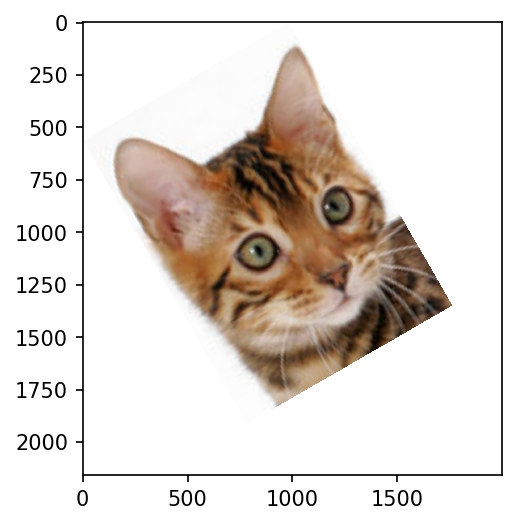

In [50]:
# TODO

# Reading the file part1/cat.jpg

cat = read_img(cat_path) 

# Cropped to the portion to show just the head

cat_crop = crop_img(cat, 0, 157, 85, 199) # 0 to 157 horizontal and 85 to 199 vertical (inclusive)

# These are rows and columns of cropped cat image

dimension = cat_crop.shape # (157, 114, 3)
r = dimension[0] - 1  # 156 rows since indexing starts at 0
c = dimension[1] - 1  # 113 columns since indexing starts at 0

angle = 30 # In degrees
positive_degree = np.radians(angle) # Converted to radians
negative_degree = np.radians(-angle) # Since rotation matrix has the form [cos(θ) -sin(θ) sin(θ) cos(θ)] 2 by 2 rotation matrix

# My projective matrix

old_M = np.array([
        [np.cos(positive_degree), np.sin(negative_degree), 0],
        [np.sin(positive_degree), np.cos(positive_degree), 0],
        [0, 0, 1]
    ]) # your 3x3 matrix

# cos(θ)  -sin(θ)

# sin(θ)   cos(θ)

scale_factor = 10

# scaling matrix

s = np.array([
    [scale_factor, 0, 0],
    [0, scale_factor, 0],
    [0, 0, 1]
])

# rotation matrix concatenated with scale matrix
# I did this because there is no scale factor in original 'M' that I used earliar
# Hence output image would be of same size as the output from cv2 (built in function) gives
# So we can multiply with scale factor depending on dsize

M = np.matmul(old_M, s)

# These are cols and rows of output image

cols = 2000 # already given in question
rows = 2160 # already given in question

output_image = manipulated_warpPerspective(cat_crop, M, (cols, rows)) 

figure(dpi = 150)
plt.imshow(output_image)
plt.show()

# 4. Cricket Stadium

In this part we will be adding an image of a cricket scoreboard to a cricket stadium.



In [51]:
# Your final output should look similar to the below given image i.e. stadium-sol5.jpg

In [4]:
import cv2

## Task 4.1

For this task, you need to transform the given scoreboard image. Your output should look similar to `transformed-scoreboard.jpg`. You can try coming up with a transformation on paper before using it. Affine transformations are a subset of projective transformations, so you can try starting from those.

(300, 640, 3)



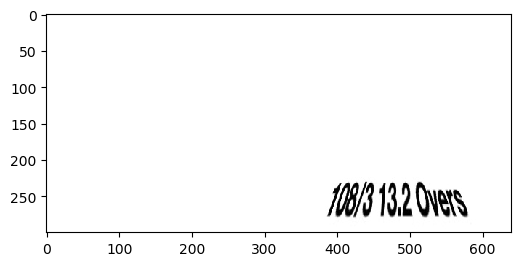

In [5]:
# transformed-scoreboard.jpg
scoreboard = read_img('tscoreboard.jpg')
print(scoreboard.shape)
print('')
show_img(scoreboard)

(46, 288, 3)



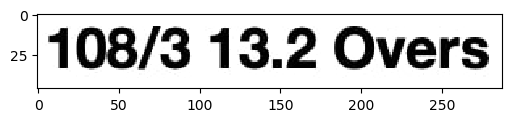

In [6]:
# start your code here
scoreboard = read_img('score.jpg')
print(scoreboard.shape)
print('')
show_img(scoreboard)

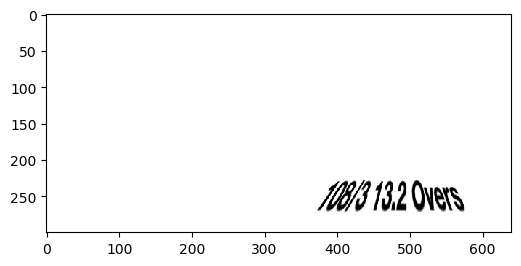

In [7]:
# Using built in cv2 functions to transform the scoreboard

to_transform = np.float32([[0, 0], [288, 0], [0, 46], [288, 46]])
transformed = np.float32([[400, 220], [560, 220], [340, 300], [600, 300]])

M = cv2.getPerspectiveTransform(to_transform, transformed)

scoreboard = cv2.warpPerspective(scoreboard, M, (640, 300), borderMode=cv2.BORDER_CONSTANT, borderValue = [255, 255, 255, 255])

show_img(scoreboard)

## Task 4.2

After you have transformed the scorebaord you have to add it to the given stadium image. This can be done by copying pixel values from the transformed scoreboard image to the given stadium image. You need to figure out the appropriate conditions for copying the pixel values. 

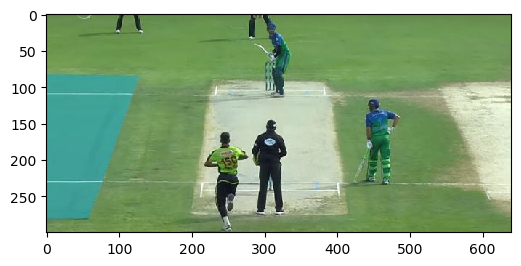

In [8]:
stadium = read_img('PSL-Stadium.jpg')
show_img(stadium)

In [9]:
# scoreboard
rows = 300
cols = 640

for i in range (rows):
    for j in range (cols):
        to_copy = scoreboard[i][j]
        if to_copy[0] < 90 and to_copy[1] < 90 and to_copy[2] < 90:  # applying thresholding to copy black as well as near to it
            stadium[i][j] = to_copy
        else:
            continue

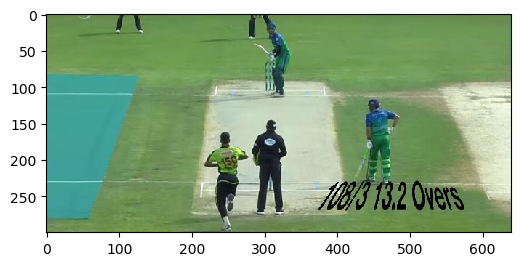

In [10]:
show_img(stadium)

## Task 4.3

In certain situations, when we want to isolate a subject in an image, alpha masks are provided to us. Alpha masks describe the transparency of an image. These masks can be in any format ranging from jpg, png, bmp, gif,etc in our example we will be using jpg.

For this part we will reproduce the same solution but by using alpha mask this time. Below you are given an alpha mask for the transfomed scoreboard. Using this alpha mask you need to combine the two images together to produce the same output.

You can achieve the desired solution as follows:

Consider the transformed scoreboard image as the foreground image and the stadium image as the background image. At every pixel of the image, we need to combine the foreground image pixel value with the background image pixel value using the alpha mask.

 
\begin{align*}
T = \alpha*F+(1-\alpha)B
\end{align*}

1. Where T is target pixel value
2. F is the pixel value in the foreground image
3. B is the pixel value of the background image
4. Alpha is value of the alpha mask for the corresponding pixels

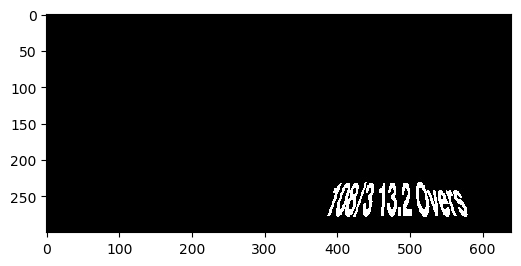

In [11]:
# score_mask.jpg
stadium = read_img('PSL-Stadium.jpg') # background image
scoreboard = read_img('tscoreboard.jpg') # without alpha mask
score_mask = read_img('score_mask.jpg') # foreground image (alpha mask of transformed score board)
show_img(score_mask)

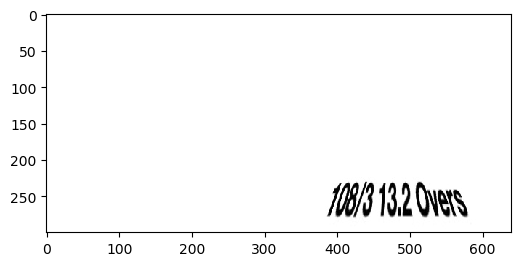

In [12]:
show_img(scoreboard)

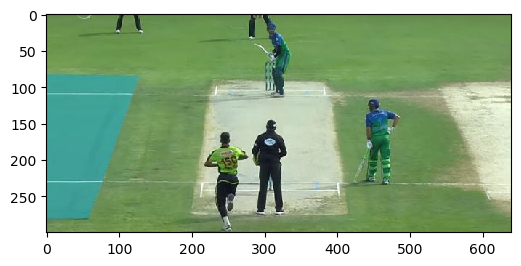

In [13]:
show_img(stadium)

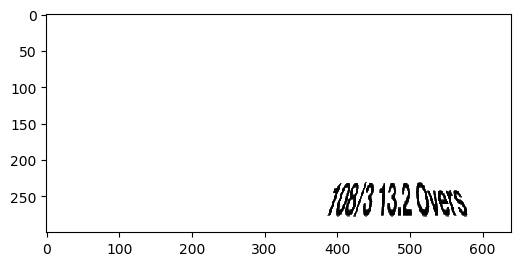

In [14]:
r = scoreboard.shape[0]
c = scoreboard.shape[1]
extracted = np.zeros((r, c, 4))

for i in range(r):
    for j in range(c):
        current = score_mask[i][j]
        if current[0] < 100 and current[1] < 100 and current[2] < 100:
            continue
        else:
            first = scoreboard[i][j][0]/255
            second = scoreboard[i][j][1]/255
            third = scoreboard[i][j][2]/255
            alpha = 1.0
            extracted[i][j] = np.array([first, second, third, alpha]) 
           
show_img(extracted) 

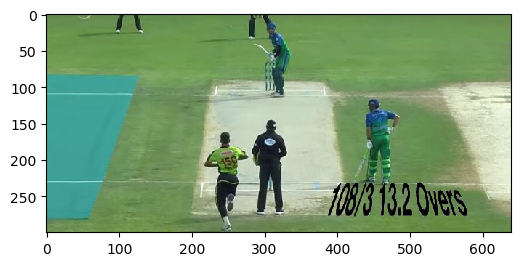

In [15]:
rows = 300
cols = 640

newstadium = np.zeros((rows, cols, 4)) # adding alpha value of 1.0 to stadium image
final = np.zeros((rows, cols, 4)) # final blended image

for i in range(rows):
    for j in range(cols):
        current = stadium[i][j]
        first = current[0]/255
        second = current[1]/255
        third = current[2]/255
        alpha = 1.0
        newstadium[i][j] = np.array([first, second, third, alpha]) 

# 𝑇=𝛼∗𝐹+(1−𝛼)𝐵
# F = scoreboard image
# B = ground image

for i in range (rows):
    for j in range (cols):
        F = extracted[i][j] # foreground (scoreboard)
        a = F[3] # alpha
        B = newstadium[i][j] # background (stadium)
        T = (a * F) + ((1 - a) * B) # target pixel
        final[i][j] = T
            
show_img(final)

# 5. Solar System (CS5310, EE513 Only, Upto 10 marks bonus for CS436)

![alt Solar System demo](https://drive.google.com/uc?id=10xxjq46hha2HS0xjyaqM-iwgrMg01d6w)

In [29]:
height = width = 1500 # shape of canvas

## Task 5.1
In this task you will try to recreate the above gif by making use of all the previously implemented techniques.

Your first task is to import the image of planet earth and apply appropriate transformations to center it within the canvas. 

You are allowed to import opencv and make use of cv2.warpPerspective(sun,M,(width, height)) 



Your result should look like (It does not matter whether the background is black or white)

Note: The resulting canvas has height and width of 1500px

![alt Sun Result](https://drive.google.com/uc?id=1IdYgql7RFwvXT1SxwuBRkW3AMKdZeexg)

## Task 5.2
In this part, you will carry out the same process for earth.jpg as well. Except, in this case the earth needs to be translated +400px on the y axis.

Your final image should look something like this

![alt Result earth](https://drive.google.com/uc?id=16eFaOHVlhUKgHpw8ZVCwSvzagJcD_s8K)

## Task 5.3
You will now modify the above code to apply rotations to the earth as such it rotates along its own axis as well as around the sun. (This is same as the problem given to you in your written assignment 1)

Feel free to copy your code from task 5.2

In [14]:
earth_func(earth,hour):
  #earth -> this is the imported earth.jpg file in numpy array format
  #hour -> You will use this parameter to caculate the rotation of earth around the sun and along its own axis. For example,
  # if hour == 15 then rotation on its own axis will be 225 deg whilst rotations around the sun will be 0.61 deg
  # return val will be the transformed image of earth such as if hours == 0 the resulting image will be the same as task 5.2
  return earth_

SyntaxError: invalid syntax (<ipython-input-14-394bdbd1f645>, line 1)

In [15]:
earths = []
for x in range(30):
  earths.append(earth_func(earth,x*10))

NameError: name 'earth_func' is not defined

## Task 5.4
You will now blend all three images to compose a single image. Feel free to make use of the canvas below.

You will have to traverse every element of the list (earths) and blend them with the transformed sun image created in task 5.1. After doing this, you will get an array of images in the end with each having a sun and a earth in them. Store this array in the variable final and run the code gif builder code in the end

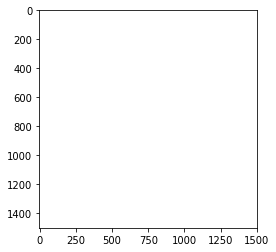

In [16]:
# Code for canvas
canvas = np.array([255]*3*width*height)
canvas.resize((width,height,3))
plt.imshow(canvas)

In [0]:
# gif builder code
# final is a list of numpy images 
imageio.mimsave('movie.gif', final)

Please submit movie.gif along with the jupyter notebook

# Submission Instructions

You are required to submit the CV_PA1 Jupyter file and Part-5 gif only via LMS. Rename CV_PA1 to CV_PA1_[your rollnumber]. 

The submitted file should be in a readable and understandable format. Add as many comments as possible. It should run from start to end without any errors. It must be in Python3.

The notebook "CV_PA1_intro" will help you get started with image manipulation. If you are familiar with it, skip it.
